# Importing necessary modules and classes and creating connection to MySQL database

In [12]:
# Python code for clustering customers based on order data retrieved from a 
# MySQL database. The code connects to the database, fetches order data, and 
# uses KMeans clustering to group customers.

import sys
sys.path.append("c:\\Users\\Mateusz\\OneDrive\\Pulpit\\Nauka\\Python\\Sales_Project\\.venv\\Lib\\site-packages")
import pandas as pd
import mysql.connector
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns


# Connection to MySQL
username = "root"
password = "admin"
host = "localhost"
database = "Cleaning_Company"

# Establish a connection to the MySQL database
connection = mysql.connector.connect(user=username, password=password, host=host, database=database)
query = f"SELECT * FROM orders_with_costs;"
orders_df = pd.read_sql(query, connection)

orders_df.head()

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_20540\2161743451.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_df = pd.read_sql(query, connection)


,order_id,cleaning_variant_fk,cleaning_duration,is_inside_cleaning,is_outside_cleaning,travel_distance,salesman_id_fk,customer_id_fk,cleaning_address,cleaning_date,variant_name,variant_standard_cost_per_hour,variant_outside_cost_per_hour,cleaning_cost_without_travel,travel_cost,total_cost,worker_first_name,worker_last_name,customer_first_name,customer_last_name
0,464,100000,4,True,False,17,50,1,"05548 Kara Loop\nFarleyville, NV 26048",2024-02-29,Fast,55,90,220,37.4,257.4,Eric,Zhang,Samuel,Doyle
1,2530,100000,8,True,False,73,37,1,"9130 Jones Hills Apt. 053\nEast Candiceville, ...",2024-02-20,Fast,55,90,440,160.6,600.6,Mark,Foster,Samuel,Doyle
2,3487,100100,11,True,False,1,41,1,"75122 Kenneth Brook\nNorth Kimberlymouth, AR 9...",2024-02-04,Standard,75,120,825,2.2,827.2,Stephanie,Prince,Samuel,Doyle
3,4860,100000,3,True,False,39,50,1,"1667 David Port\nNew Anthony, GA 77889",2024-02-09,Fast,55,90,165,85.8,250.8,Eric,Zhang,Samuel,Doyle
4,7945,100000,6,True,False,77,17,1,Unit 4584 Box 6917\nDPO AA 30972,2024-03-03,Fast,55,90,330,169.4,499.4,Lisa,Goodwin,Samuel,Doyle


# Pivoting necessary data (count of orders by variant)

In [38]:
orders_by_customer = pd.pivot_table(
    orders_df, 
    "order_id", 
    "customer_id_fk", 
    "variant_name", 
    aggfunc="count").fillna(0)

orders_by_customer.head()

variant_name,Fast,Premium,Silver,Standard,VIP
customer_id_fk,,,,,
1,6.0,1.0,0.0,2.0,0.0
2,3.0,0.0,1.0,4.0,0.0
3,4.0,1.0,2.0,9.0,1.0
4,0.0,0.0,4.0,4.0,1.0
5,6.0,2.0,0.0,0.0,0.0


# Standardizing data

In [14]:
scaler = StandardScaler()
standarized_orders_by_customers = orders_by_customer.copy()

In [50]:
for column in standarized_orders_by_customers:
    standarized_orders_by_customers[column] = scaler.fit_transform(
        pd.DataFrame(standarized_orders_by_customers[column])
    )

standarized_orders_by_customers.head()

variant_name,Fast,Premium,Silver,Standard,VIP,cluster_label
customer_id_fk,,,,,,
1,0.421860,-0.022004,-1.257634,-1.352319,-0.505039,0.251842
2,-0.893279,-1.019499,-0.438289,-0.454076,-0.505039,0.251842
3,-0.454900,-0.022004,0.381056,1.791534,1.560686,-0.365284
4,-2.208418,-1.019499,2.019746,-0.454076,1.560686,-1.599536
5,0.421860,0.975492,-1.257634,-2.250563,-0.505039,-0.982410


# Creating and displaying "Elbow Plot"
## (How many clusters are needed)

In [51]:
def elbow_plot(data, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Plot')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()

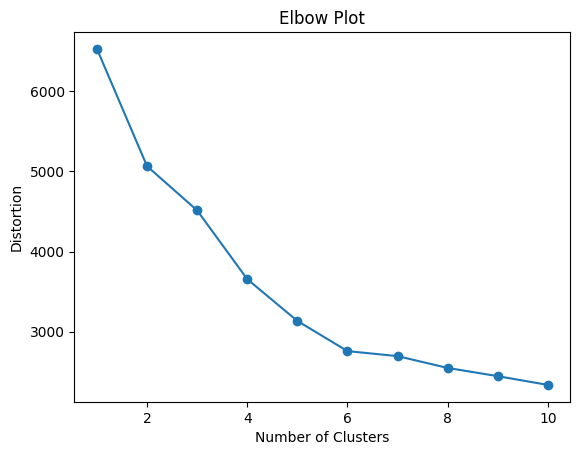

In [52]:
elbow_plot(standarized_orders_by_customers)

# Creating clusters
### The Elbow Plot method determined that 6 is the appropriate number of clusters

In [45]:
# Select appropriate features for clustering algorithm
features = standarized_orders_by_customers[list(standarized_orders_by_customers.columns)]

# Determine the number of clusters
num_clusters = 6

# Create an instance of the KMeans model
kmeans = KMeans(n_clusters=num_clusters)

# Train the model on the data
kmeans.fit(features)

# Assign cluster labels to the data
labels = kmeans.labels_

# Add a column with labels to the data
standarized_orders_by_customers['cluster_label'] = labels

# Display the results
standarized_orders_by_customers.head()

variant_name,Fast,Premium,Silver,Standard,VIP,cluster_label
customer_id_fk,,,,,,
1,0.421860,-0.022004,-1.257634,-1.352319,-0.505039,3
2,-0.893279,-1.019499,-0.438289,-0.454076,-0.505039,3
3,-0.454900,-0.022004,0.381056,1.791534,1.560686,2
4,-2.208418,-1.019499,2.019746,-0.454076,1.560686,0
5,0.421860,0.975492,-1.257634,-2.250563,-0.505039,1


In [37]:
clusters_means = standarized_orders_by_customers.groupby("cluster_label").mean()
clusters_means

variant_name,Fast,Premium,Silver,Standard,VIP
cluster_label,,,,,
0,-0.084335,-0.115691,1.653077,-0.034730,0.042777
1,-0.480814,-0.444588,-0.385819,1.116745,-0.443984
2,1.491283,-0.238022,-0.339133,-0.196617,-0.386622
3,-0.146319,1.549470,-0.273505,-0.228260,-0.297313
4,-0.438039,-0.549525,-0.351628,-0.661363,-0.505039
5,-0.024739,-0.090581,-0.284662,-0.069515,1.883455


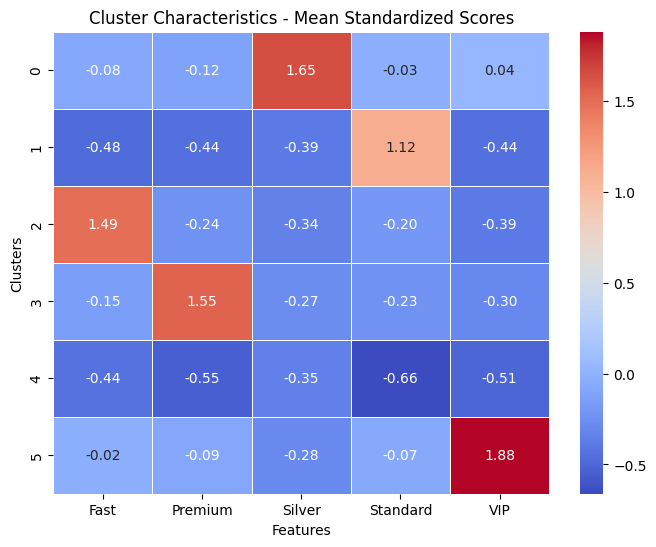

In [54]:
# Plotting
plt.figure(figsize=(8,6), facecolor='white')
sns.heatmap(clusters_means, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.6)
plt.title('Cluster Characteristics - Mean Standardized Scores')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

In [1]:
customers_type = {
    0 : "standard",
    1 : "silver",
    2 : "premium",
    3 : "undefined",
    4 : "vip",
    5 : "fast"
}

In [ ]:
order